# Local Classifier Two-Sample Tests ($\ell$-C2ST)

After a density estimator has been trained with simulated data to obtain a posterior, the estimator should be made subject to several diagnostic tests, before being used for inference given the actual observed data. _Posterior Predictive Checks_ (see [previous tutorial](https://sbi-dev.github.io/sbi/tutorial/12_diagnostics_posterior_predictive_check/)) provide one way to "critique" a trained estimator via its predictive performance. Another approach is simulation-based calibration (see [previous tutorial](https://sbi-dev.github.io/sbi/tutorial/13_diagnostics_simulation_based_calibration/)), that evaluates whether the estimated posterior is balanced, i.e., neither over-confident nor under-confident. These checks are peformed ***in expectation (on average) over the observation space***. As such, SBC is a ***global*** validation method that can be viewed as a necessary condition (but not sufficient) for a valid inference algorithm: If SBC checks fail, this tells you that your inference is invalid. If SBC checks pass, *this is no guarantee that the posterior estimation is working*. Local Classifier Two-Sample Tests as developed by [Linhart et al, 2023](https://arxiv.org/abs/2306.03580) present a new ***local*** validation method that allow to evaluate the correctness of the posterior estimator ***at a fixed observation***. They provide necessary *and sufficient* conditions for the validity of the SBI-algorithm, as well as easy-to-interpret qualitative and quantiative diagnostics: If global checks (like SBC) fail, this enables to further investigate where (for which observation) and why (bias, overdispersion, etc.) the posterior estimator fails. If global validation checks pass, this allows to guarantee whether the inference is correct for a specific observation. 

**Local Classifier Two-Sample Tests** ($\ell$-C2ST) ...


## In a nutshell

Suppose your posterior estimator $q_\phi(\theta\mid x)$ was trained in an amortized way, meaning that we can quickly get samples for any new observation $x$.

To run $\ell$-C2ST, 

1. we sample **new** parameters from the prior of the problem at hand: $\Theta_i \sim p(\theta)$
2. we simulate corresponding "observations": $X_i = \mathrm{Simulator}(\Theta_i) \sim p(x\mid \Theta_i)$
3. we sample the estimated posterior at each observation: $Q_i \sim q_\phi(\theta \mid X_i)$

This creates a dataset of samples from the "estimated" and true joint distributions on which we train a binary classifier $d(\theta, x)$ to distinguish between:
- Class 0: the estimated joint $q(\theta \mid x)p(x)$
- Class 1: for the true joint distribution $p(\theta)p(x\mid\theta)$

Once the classifier is trained, we evaluate it for a given observation $x^\star$ and multiple samples $Q^\star_n \sim q_\phi(\theta \mid x^\star)$. This gives us a set of predicted probabilities $d(Q^\star_n, x^\star)$, that are then used to compute the different diagnostics:
- quantitative: test statistic, p-values 
- qualitative: heatmaps, PP-plots with confidence regions 
This proceedure can be repeated for several different observations, without having to retrain the classifiers, which allows to perform a thorough analysis of the failure modes of the posterior estimator.

**Quick reminder on hypothesis tests.** Additionaly to the observed test statistic $T^\star$, evaluating the test requires to
1. compute the "optimal" test statistics $T_h$ under the null hyposthesis (H0) of equal (true and estimated) distributions over multiple trials $h$ 
2. compute the p-value $p_v = \frac{1}{H}\sum_{h=1}^H \mathbb{I}(T_h > T^\star)$: *"How many times is the observed test statistic "better" (i.e. below) the optimal test statistic (under H0)?"*
3. choose a significance level $\alpha$ (typically $0.05$) that defines the rejection threshold and evaluate the test
- quantitatively: a p-value below this level indicates the rejection of the null hypothesis, meaning the detection of significant differences between the true and the estimated posterior. 
- qualitatively: visually check whether $T^\star$ falls into the $1-\alpha$ confidence region, computed by taking the corresponding quantiles of $(T_1,\dots, T_H)$.

### Key ideas behind $\ell$-C2ST

...

### What can $\ell$-C2ST diagnose?

...

To summarize $\ell$-C2ST can:

- ...
- ...

## Illustration on a benchmark example

We consider the Gaussian Mixture SBI task from [Lueckmann et al, 2021](https://arxiv.org/abs/2101.04653). It consists of inferring the common mean of a mixture of two two-dimensional Gaussian distributions, one with much broader covariance than the other:
- Prior: $p(\theta) = \mathcal{U}(-10,10)$
- Simulator: $p(x|\theta) = 0.5 \mathcal{N}(\theta, \mathbf{I}_2)+ 0.5 \mathcal{N}(\theta, 0.1 \times \mathbf{I}_2)$
- Dimensionality: $\theta \in \mathbb{R}^2$, $x \in \mathbb{R}^2$

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Number of samples to train the density estimator
N_TRAIN = 2_000
N_CAL = 1_000

### Task and Data

In [12]:
from utils_17_diagnostics_lc2st import GaussianMixture

# SBI task: prior and simualtor
gmm = GaussianMixture()
prior = gmm.prior_dist
simulator = gmm.get_simulator()

# Sample training data for the density estimator
torch.manual_seed(42)
theta_train = prior.sample((N_TRAIN,))
x_train = simulator(theta_train)

print(f"theta shape = {theta_train.shape}")
print(f"x shape = {x_train.shape}")

theta shape = torch.Size([2000, 2])
x shape = torch.Size([2000, 2])


### Posterior Inference

We use neural posterior estimation as our SBI-algorithm with a MAF as underlying density estimator.

> Note: Here you could use any other SBI algorithm of your own choosing (e.g. NRE, NLE, etc.). IMPORTANT: make sure it is amortized (which corresponds to sequential methods with a signle round). 

In [13]:
from sbi.inference import SNPE, prepare_for_sbi

# Prepare the simulator and prior for inference
simulator, prior = prepare_for_sbi(simulator, prior)

# Train the neural posterior estimators
inference = SNPE(prior, density_estimator='maf', device='cpu')
inference = inference.append_simulations(theta=theta_train, x=x_train)
npe = inference.train(max_num_epochs=10)



 Training neural network. Epochs trained: 11

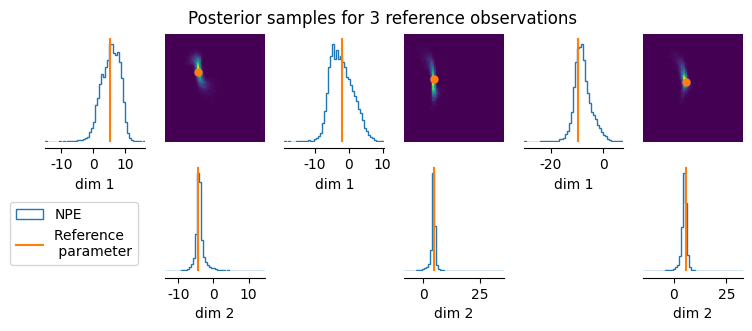

In [14]:
# get reference observations
torch.manual_seed(1)
thetas_star = prior.sample((3,))
xs_star = simulator(thetas_star)

# Sample from the learned posterior
post_samples_star = {}
for i,x in enumerate(xs_star):
    post_samples_star[i] = npe.sample((10_000,), condition=x).detach()


# Plot the posterior samples
from sbi.analysis.plot import pairplot

fig, axes = plt.subplots(2, 6, figsize=(9, 3))
legend_kwargs = {'labels': ["NPE", "Reference \n parameter"], 'bbox_to_anchor': (1,-.5)}
for i in range(len(thetas_star)):
    legend = True if i==0 else False
    pairplot(
        post_samples_star[i],
        points=thetas_star[i],
        legend=legend,
        legend_kwargs=legend_kwargs,
        fig=fig,
        axes=axes[:,i*2:2*(i+1)]
    )
plt.suptitle(f"Posterior samples for {len(thetas_star)} reference observations")
plt.show()



### Evaluate the posterior estimator

In [15]:
from sbi.diagnostics.lc2st import LC2ST

# sample calibration data
theta_cal = prior.sample((N_CAL,))
x_cal = simulator(theta_cal)
post_samples_cal = npe.sample((1,), x_cal)[:,0,:].detach()

lc2st = LC2ST(thetas=theta_cal, xs=x_cal, posterior_samples=post_samples_cal, n_folds=1)
_ = lc2st.train_null()
_ = lc2st.train_data()

Training the classifiers under (H0) - permutation = True: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


LC2ST scores: [0.11715284]
Predicted probabilities (class 0): [0.6274349]
Test statistic: 0.1171528351724215



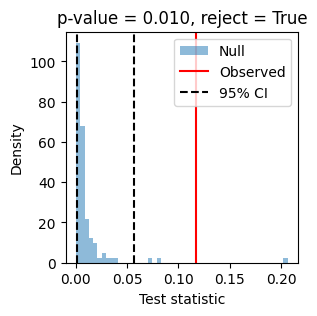

LC2ST scores: [0.11495001]
Predicted probabilities (class 0): [0.6644953]
Test statistic: 0.11495000912863496



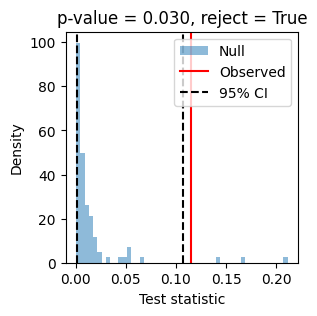

LC2ST scores: [0.15051528]
Predicted probabilities (class 0): [0.78980124]
Test statistic: 0.1505152835489385



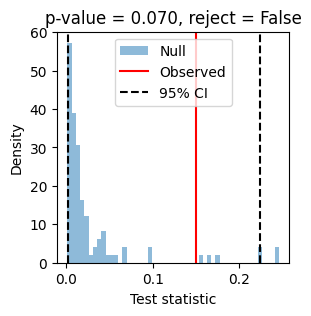

In [16]:
alpha = 0.05
for i in range(len(thetas_star)):
    probas, scores = lc2st.scores_data(
        P_eval=post_samples_star[i],
        x_eval=xs_star[i],
        return_probas=True
    )
    T_star = lc2st.statistic_data(P_eval=post_samples_star[i], x_eval=xs_star[i])

    print(f"LC2ST scores: {scores}")
    print(f"Predicted probabilities (class 0): {probas.mean(axis=1)}")
    print(f"Test statistic: {T_star}")
    print()


    T_null = lc2st.statistics_null(P_eval=post_samples_star[i], x_eval=xs_star[i])
    p_value = lc2st.p_value(post_samples_star[i], xs_star[i])
    reject = lc2st.reject(post_samples_star[i], xs_star[i], alpha=alpha)

    # plot 95% confidence interval
    quantiles = np.quantile(T_null, [alpha/2, 1-alpha/2])
    plt.figure(figsize=(3, 3))
    plt.hist(T_null, bins=50, density=True, alpha=0.5, label="Null")
    plt.axvline(T_star, color="red", label="Observed")
    plt.axvline(quantiles[0], color="black", linestyle="--", label="95% CI")
    plt.axvline(quantiles[1], color="black", linestyle="--")
    plt.xlabel("Test statistic")
    plt.ylabel("Density")
    plt.legend()
    plt.title(f"p-value = {p_value:.3f}, reject = {reject}")
    plt.show()